In [194]:
!pip install qgrid

In [195]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import qgrid
import ast

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

In [196]:
pred_df = pd.read_csv("pred_df.csv")

In [197]:
pred_df.columns

Index(['Unnamed: 0', 'Title', 'User Score', 'index', 'Unnamed: 0.1', 'Type',
       'English Alternative Names', 'Synonyms', 'Japanese Alternative Names',
       'Episodes', 'Score', 'Studios', 'Start Year', 'Premiered', 'Hyperlink',
       'Synopsis', 'Source', 'Genres', 'Duration', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Total', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', 'ScoredCount', 'Aired', 'Broadcast', 'End Year',
       'Premiered Season', 'Premiered Year', 'First', 'Prequel', 'Sequel',
       'Cars', 'Shounen', 'Fantasy', 'School', 'Seinen', 'Martial Arts',
       'Adventure', 'No genres have been added yet.', 'Super Power', 'Harem',
       'Dementia', 'Shoujo', 'Psychological', 'Romance', 'Parody', 'Horror',
       'Sports', 'Sci-Fi', 'Hentai', 'Military', 'Mystery', 'Space', 'Game',
       'Historical', 'Kids', 'Slice of Life', 'Thriller', 'Samurai', 'Comedy',
       'Josei'

In [198]:
heatmap_df = pred_df.iloc[:,48:91]
heatmap_df["User Score"] = pred_df["User Score"]
heatmap_df["Score"] = pred_df["Score"]
#heatmap_df

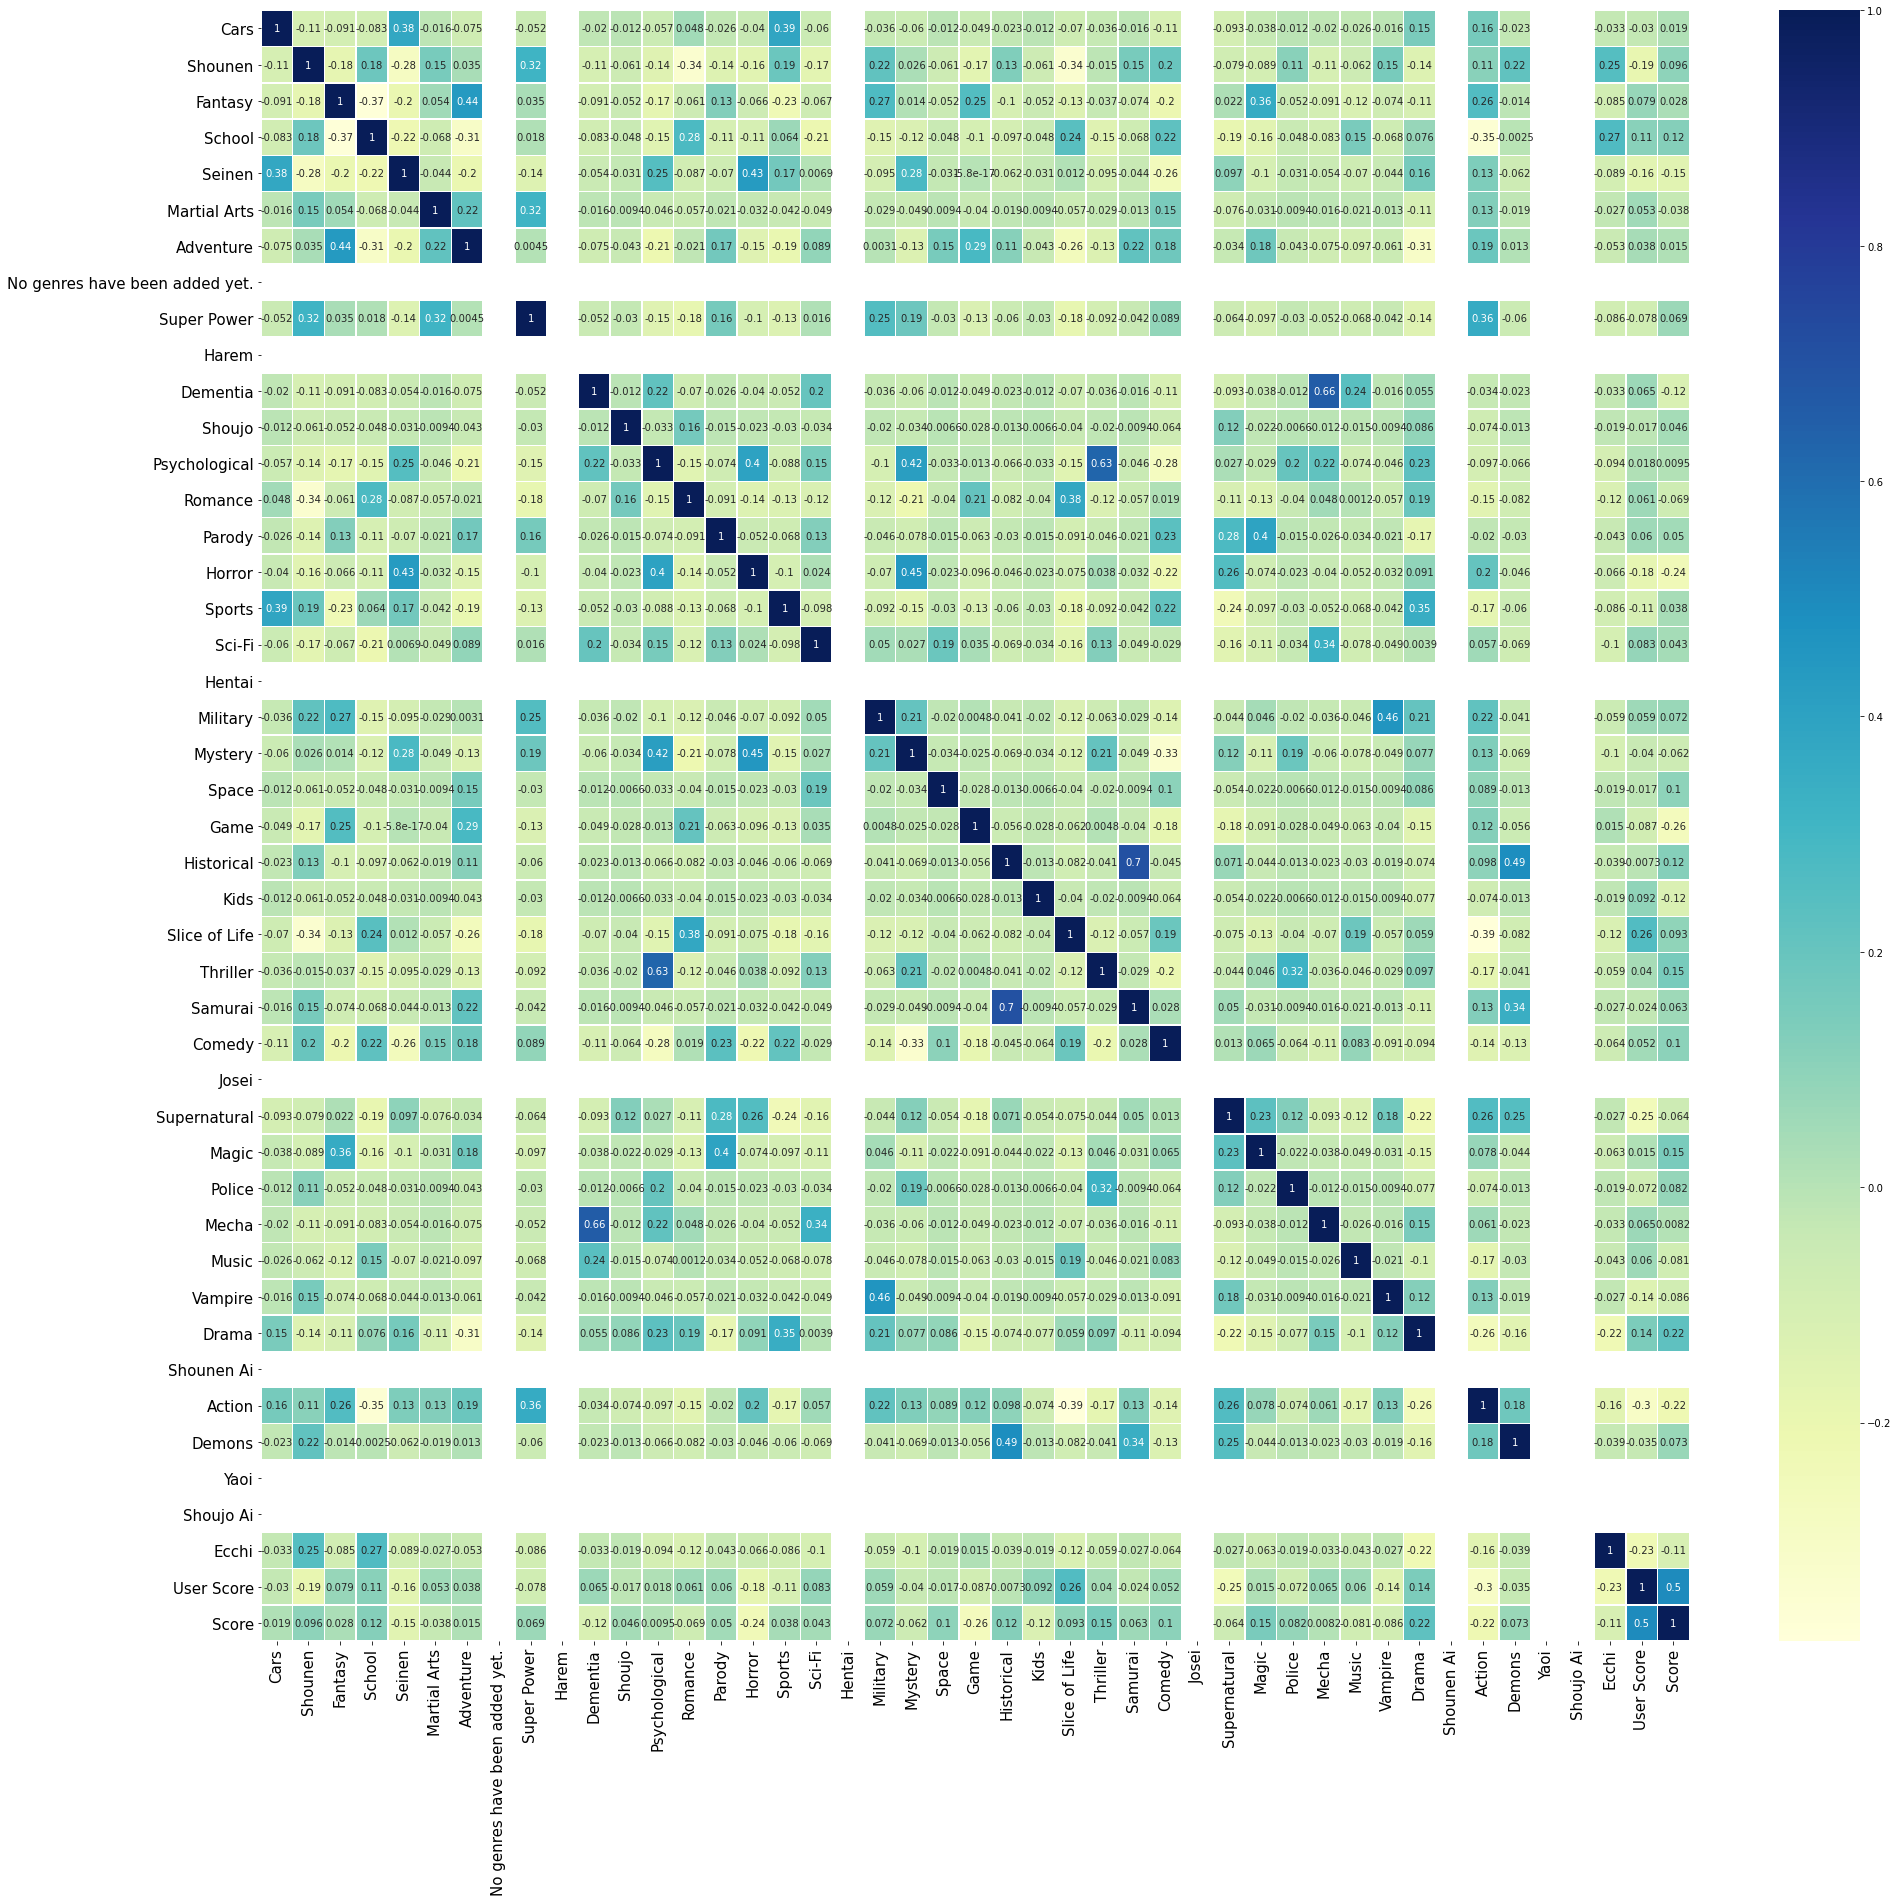

In [199]:
plt.figure(figsize=(32,30))
cor = heatmap_df.corr()
sns.heatmap(cor, annot=True, cmap="YlGnBu", linewidths=.5)
plt.yticks(rotation= 0, fontsize=15)
plt.xticks(rotation=90, fontsize=15)
plt.show()

In [200]:
must_include = False
include = ["Romance", "Harem", "Comedy", "Ecchi", "School"]

def and_operation(c1, c2, c3=1):
    return (c1 and c2 and c3) * 1

g_column_names = ["Genres", "Score Diff", "User Score", "User Var", "MAL Score", "Freq"]
g_df = pd.DataFrame(columns = g_column_names)

In [201]:
for genre in heatmap_df.iloc[:,:-2].columns:
    genre_mean = heatmap_df[genre].mean()
    # at least x% of shows have this genre
    if (genre_mean > 0.06) and ((must_include and (genre in include)) or (not must_include)):
        temp_df = heatmap_df[heatmap_df[genre] == 1]
        g_u_mean = temp_df["User Score"].mean()
        g_var = temp_df["User Score"].std() ** 2
        g_m_mean = temp_df["Score"].mean()
        g_col = [genre, g_u_mean - g_m_mean, g_u_mean, g_var, g_m_mean, genre_mean]
        g_df.loc[len(g_df.index)] = g_col

In [202]:
for genre1 in heatmap_df.iloc[:,:-2].columns:
    for genre2 in heatmap_df.iloc[:,:-2].columns:
        if (genre1 < genre2) and ((must_include and ((genre1 in include) or (genre2 in include))) or (not must_include)):
            comb_col = heatmap_df.apply(lambda x: and_operation(x[genre1], x[genre2]), axis=1)
            genre_mean = comb_col.mean()

            if (genre_mean > 0):
                temp_df = heatmap_df[comb_col == 1]
                g_u_mean = temp_df["User Score"].mean()
                g_var = temp_df["User Score"].std() ** 2
                g_m_mean = temp_df["Score"].mean()
                g_col = [genre1 + " " + genre2, g_u_mean - g_m_mean,
                             g_u_mean, g_var, g_m_mean, genre_mean]
                g_df.loc[len(g_df.index)] = g_col

In [203]:
for genre1 in heatmap_df.iloc[:,:-2].columns:
    for genre2 in heatmap_df.iloc[:,:-2].columns:
        for genre3 in heatmap_df.iloc[:,:-2].columns:
            if (genre1 < genre2 < genre3) and ((must_include 
                                      and ((genre1 in include) or (genre2 in include) or (genre3 in include))) or (not must_include)):
                comb_col = heatmap_df.apply(lambda x: and_operation(x[genre1], x[genre2], x[genre3]), axis=1)
                genre_mean = comb_col.mean()

                if (genre_mean > 0.1):
                    temp_df = heatmap_df[comb_col == 1]
                    g_u_mean = temp_df["User Score"].mean()
                    g_var = temp_df["User Score"].std() ** 2
                    g_m_mean = temp_df["Score"].mean()
                    g_col = [genre1 + " " + genre2 + " " + genre3, g_u_mean - g_m_mean,
                             g_u_mean, g_var, g_m_mean, genre_mean]
                    g_df.loc[len(g_df.index)] = g_col

Just some thoughts...frequency isn't very telling because some tags get used a lot more than others. **Score Diff** is the key column to look at here, showing how you tend to rate genres compared to the average MAL user (aka what you are interested in more than other people). Also, **User Var** is the variance of your ratings for that genre, or how varied/spread out those ratings are (consistently mediocre or lots of highs and lows).

In [204]:
#g_df
qgrid.show_grid(g_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

(1.0, 10.0)

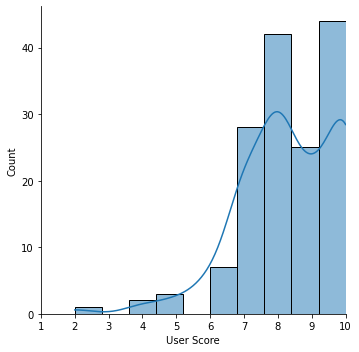

In [205]:
sns.displot(pred_df["User Score"], bins=10, kde=True)
plt.xlim(1, 10)

(1.0, 10.0)

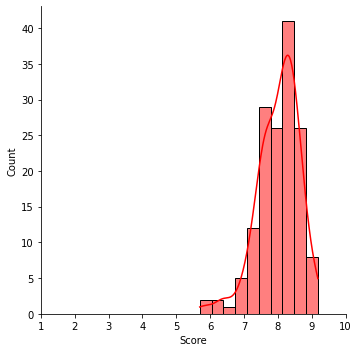

In [206]:

sns.displot(pred_df["Score"], bins=10, color='r', kde=True)
plt.xlim(1, 10)

In [207]:
pred_df["User Score"].mean()

8.31578947368421

In [208]:
pred_df['Threshold'] = np.where(pred_df['User Score'] >= 6, 1, 0)

Will need to OHE studios and source at some point

In [209]:
pred_df

,Unnamed: 0,Title,User Score,index,Unnamed: 0.1,Type,English Alternative Names,Synonyms,Japanese Alternative Names,Episodes,...,Music,Vampire,Drama,Shounen Ai,Action,Demons,Yaoi,Shoujo Ai,Ecchi,Threshold
0,0,3-gatsu no Lion,9,19,19,TV,March comes in like a lion,Sangatsu no Lion,3月のライオン,22,...,0,0,1,0,0,0,0,0,0,1
1,1,3-gatsu no Lion 2nd Season,10,20,20,TV,March Comes In Like A Lion 2nd Season,Sangatsu no Lion Second Season,3月のライオン 第2シリーズ,22,...,0,0,1,0,0,0,0,0,0,1
2,2,Accel World,7,44,44,TV,Accel World,Accelerated World,アクセル・ワールド,24,...,0,0,0,0,1,0,0,0,0,1
3,3,Ahiru no Sora,7,64,64,TV,NaN,NaN,あひるの空,50,...,0,0,1,0,0,0,0,0,0,1
4,4,Ajin,6,90,90,TV,Ajin: Demi-Human,Ajin,亜人,13,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,147,Yowamushi Pedal: Glory Line,5,659,659,TV,NaN,"Yowamushi Pedal 4th Season, Yowapeda 4th Season",弱虫ペダル GLORY LINE,25,...,0,0,1,0,0,0,0,0,0,0
148,148,Yowamushi Pedal: Grande Road,8,660,660,TV,NaN,"Yowamushi Pedal 2nd Season, Yowapeda 2nd Season",弱虫ペダル GRANDE ROAD,24,...,0,0,1,0,0,0,0,0,0,1
149,149,Yowamushi Pedal: New Generation,7,661,661,TV,NaN,"Yowamushi Pedal 3rd Season, Yowapeda 3rd Season",弱虫ペダル NEW GENERATION,25,...,0,0,1,0,0,0,0,0,0,1
150,150,Yu☆Gi☆Oh! Duel Monsters,10,667,667,TV,Yu-Gi-Oh!,"Yugioh, Yu-Gi-Oh!, Yu-Gi-Oh!: Duel Monsters, Y...",遊☆戯☆王 デュエルモンスターズ,224,...,0,0,0,0,0,0,0,0,0,1


### Classification

In [236]:
potential_col_list = ['Studios', 'First', 'Source', 'Ranked', 'Popularity', 'Members', 'Favorites', 'ScoredCount', 'Duration', 'Episodes']
other_genres = ['Cars', 'Martial Arts',
       'No genres have been added yet.', 'Parody', 'Hentai', 'Space', 'Game',
       'Kids', 
       'Josei', 'Police', 'Music', 'Vampire',
       'Shounen Ai', 'Demons', 'Yaoi', 'Shoujo Ai', 'Dementia',
        'Shounen', 'Fantasy', 'School', 'Seinen', 'Adventure', 
        'Super Power', 'Harem', 'Shoujo', 'Psychological', 'Romance', 'Horror',
        'Sports', 'Sci-Fi', 'Military', 'Mystery', 'Historical', 'Slice of Life', 'Thriller', 'Samurai', 'Comedy',
        'Supernatural', 'Magic', 'Mecha', 'Drama', 'Action', 'Ecchi'
       ]

col_g_list = []
for genre in heatmap_df.iloc[:,:-2].columns:
    genre_mean = heatmap_df[genre].mean()
    # at least x% of shows have this genre
    if (genre_mean > 0.0105):
        col_g_list.append(genre)
    
col_list = [
       'Score', 'Start Year'
       ]
col_list.extend(col_g_list)


In [237]:
def ohe(col, df):
    unique_list = list(np.unique(pred_df[col]))
    df = df.reindex(df.columns.tolist() + unique_list, axis=1, fill_value=0)
    for index, row in df.iterrows():
        val = row[col]
        df.loc[index, val] = 1
    return df, unique_list

ohe_df, studios_list = ohe("Studios", pred_df)

col_list.extend(studios_list)

In [238]:
# can also comment out cell above and use pred_df instead of ohe_df for this cell and all after
features = ohe_df[col_list].copy()
labels = ohe_df['Threshold']

In [239]:
## Train — test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.32, random_state=42)

## Validation
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

#### RF

In [240]:
def print_results(results):
    print("BEST PARAMS: {}\n".format(results.best_params_))
        
    means = results.cv_results_["mean_test_score"]
    stds = results.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, results.cv_results_["params"]):
         print("{} (+/-{}) for {}".format(round(mean, 3), round(std * 2, 3), params))
    
    return results.best_params_

rf = RandomForestClassifier()
parameters = {
 "n_estimators": [50, 100],
 "max_depth": [10, 20, None]
}
rf_cv = GridSearchCV(rf, parameters, cv=5)
rf_cv.fit(X_train, y_train.values.ravel())
rf_best = print_results(rf_cv)

BEST PARAMS: {'max_depth': 10, 'n_estimators': 50}

0.951 (+/-0.002) for {'max_depth': 10, 'n_estimators': 50}
0.951 (+/-0.002) for {'max_depth': 10, 'n_estimators': 100}
0.951 (+/-0.002) for {'max_depth': 20, 'n_estimators': 50}
0.951 (+/-0.002) for {'max_depth': 20, 'n_estimators': 100}
0.951 (+/-0.002) for {'max_depth': None, 'n_estimators': 50}
0.951 (+/-0.002) for {'max_depth': None, 'n_estimators': 100}


In [241]:
rf_model = RandomForestClassifier(n_estimators=rf_best["n_estimators"], max_depth=rf_best["max_depth"])
rf_model.fit(X_train, y_train)
rf_predicted_values = rf_model.predict(X_test)
score = accuracy_score(y_test,rf_predicted_values)
print(score)

1.0


C:\Users\Kevin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86]),
 [Text(0, 0, 'Score'),
  Text(1, 0, 'Start Year'),
  Text(2, 0, 'Cars'),
  Text(3, 0, 'Shounen'),
  Text(4, 0, 'Fantasy'),
  Text(5, 0, 'School'),
  Text(6, 0, 'Seinen'),
  Text(7, 0, 'Martial Arts'),
  Text(8, 0, 'Adventure'),
  Text(9, 0, 'Super Power'),
  Text(10, 0, 'Dementia'),
  Text(11, 0, 'Psychological'),
  Text(12, 0, 'Romance'),
  Text(13, 0, 'Parody'),
  Text(14, 0, 'Horror'),
  Text(15, 0, 'Sports'),
  Text(16, 0, 'Sci-Fi'),
  Text(17, 0, 'Military'),
  Text(18, 0, 'Mystery'),
  Text(19, 0, 'Game'),
  Text(20, 0, 'Historical'),
  Text(21, 0, 'Slice of Life'),
  Text(22, 0, 'Thriller

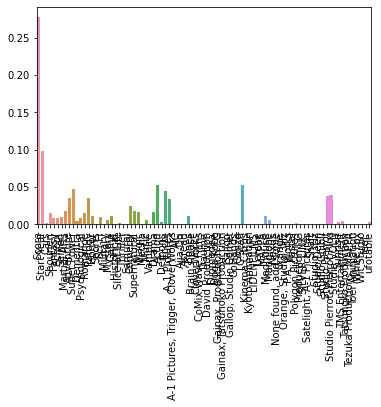

In [242]:
fi_name=[]
fi_imp = []
for name, importance in zip(features.columns, rf_model.feature_importances_):
    fi_name.append(name)
    fi_imp.append(importance)

sns.barplot(fi_name, fi_imp)
plt.xticks(rotation=90, fontsize=10)

#### MLP

In [243]:
mlp = MLPClassifier()
parameters = {
 "hidden_layer_sizes": [(10,), (50,)],
 "activation": ["relu", "logistic"]
}
mlp_cv = GridSearchCV(mlp, parameters, cv=5)
mlp_cv.fit(X_train, y_train.values.ravel())
mlp_best = print_results(mlp_cv)

C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\neural_network\_multi

BEST PARAMS: {'activation': 'relu', 'hidden_layer_sizes': (10,)}

0.951 (+/-0.002) for {'activation': 'relu', 'hidden_layer_sizes': (10,)}
0.409 (+/-0.884) for {'activation': 'relu', 'hidden_layer_sizes': (50,)}
0.951 (+/-0.002) for {'activation': 'logistic', 'hidden_layer_sizes': (10,)}
0.951 (+/-0.002) for {'activation': 'logistic', 'hidden_layer_sizes': (50,)}


In [244]:
mlp_model = MLPClassifier(activation=mlp_best["activation"], hidden_layer_sizes=mlp_best["hidden_layer_sizes"])
mlp_model.fit(X_train, y_train)
mlp_predicted_values = mlp_model.predict(X_test)
score = accuracy_score(y_test,mlp_predicted_values)
print(score)

1.0


In [245]:
models = {'RF':rf_cv.best_estimator_, 'MLP':mlp_cv.best_estimator_}

In [246]:
def evaluate_model(name, model, features, labels):
    pred = model.predict(features)
    accuracy = round(accuracy_score(labels, pred), 3)
    print('{} -- Accuracy: {}'.format(name,accuracy))
                                                    
                                                      
for name, mdl in models.items():
    evaluate_model(name, mdl, X_val, y_val)

RF -- Accuracy: 0.917
MLP -- Accuracy: 0.958


### Estimation (Train-test)

In [247]:
'''
model = SVR(kernel="linear")
model = Ridge()
model = LinearRegression()
model = SVR(kernel="rbf")
model = RandomForestRegressor(n_estimators=10, random_state=1)

r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=10)
model = VotingRegressor([('lr', r1), ('rf', r2)])
'''
model = Ridge()

In [248]:
## Train — test
X_train, X_test, y_train, y_test = train_test_split(features, pred_df["User Score"], test_size=0.3, random_state=40)
model.fit(X_train, y_train)
try:
    print(model.coef_)
except:
    pass

[ 1.21951244 -0.00402227 -0.41007001 -0.8872837   0.03259761  0.47417855
 -0.38966428  1.34692917 -0.05758035 -0.92573106  0.24917845  0.39189023
 -0.21109449  0.50430243 -0.30266824 -0.8818692  -0.47363656  0.15236949
  0.24311773 -0.01722562 -0.43939429 -0.05591218 -0.70395371  0.22269473
 -0.04331179 -1.07463522  0.18070863  0.08009589 -0.03554139  0.
 -0.40662185 -0.236689    0.36004346 -0.67953257 -0.95796919 -0.16908256
  0.          0.          0.69859452  0.46595853 -0.10120176  0.50607874
 -0.21616872  0.80690151  1.0887473   0.         -0.05616734  0.00645249
  0.24272596  1.0603254   0.          0.08209028  0.19542842 -0.93255719
  0.18227215  0.20334501 -0.41338633  0.13658356 -0.15590781 -0.44486987
  0.          0.          0.         -0.08716864  0.          0.
 -0.1627125  -0.42566317 -0.02119447 -0.33396603 -0.50659603  0.05070636
  0.          0.42155939 -0.66208902 -1.10715619 -0.89322502  0.
 -0.61460257  0.57758644  0.53715424  0.22269473  0.83047629  0.09915285
  

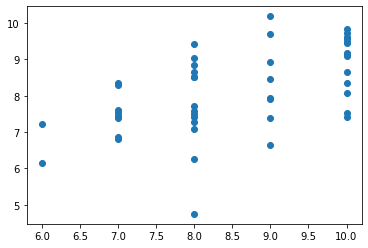

In [249]:
predictions = model.predict(X_test)
plt.scatter(y_test, predictions)

(array([ 6.,  7.,  3.,  9., 10.,  3.,  3.,  1.,  3.,  1.]),
 array([-1.41967986, -0.95240023, -0.48512059, -0.01784096,  0.44943867,
         0.91671831,  1.38399794,  1.85127757,  2.31855721,  2.78583684,
         3.25311647]),
 <BarContainer object of 10 artists>)

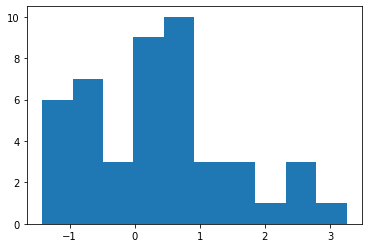

In [250]:
plt.hist(y_test - predictions)

In [251]:
print(
metrics.mean_absolute_error(y_test, predictions),
metrics.mean_squared_error(y_test, predictions),
np.sqrt(metrics.mean_squared_error(y_test, predictions))
)

0.9428671311259942 1.3883342495427167 1.1782759649346652


### Fitting the model

In [252]:
from scipy import stats
our_predictions = model.predict(ohe_df[col_list].copy())
ohe_df["Predictions"] = our_predictions
predicted_diff = (ohe_df["Predictions"] - ohe_df["Score"])
ohe_df["Normalized Predicted Diff"] = stats.zscore(predicted_diff)
ohe_df["Shifted Predicted Diff"] = predicted_diff - np.mean(predicted_diff)

In [253]:
ohe_df[["Title", "Score",  "User Score", "Predictions", "Normalized Predicted Diff", "Shifted Predicted Diff"]]

,Title,Score,User Score,Predictions,Normalized Predicted Diff,Shifted Predicted Diff
0,3-gatsu no Lion,8.421,9,9.129097,0.574507,0.523668
1,3-gatsu no Lion 2nd Season,8.991,10,9.820197,0.707364,0.644768
2,Accel World,7.301,7,7.518980,0.036809,0.033551
3,Ahiru no Sora,7.321,7,6.849376,-0.719744,-0.656053
4,Ajin,7.471,6,6.603075,-1.154518,-1.052353
...,...,...,...,...,...,...
147,Yowamushi Pedal: Glory Line,7.581,5,7.273879,-0.539270,-0.491549
148,Yowamushi Pedal: Grande Road,8.101,8,7.924115,-0.396391,-0.361314
149,Yowamushi Pedal: New Generation,7.681,7,7.399853,-0.510775,-0.465576
150,Yu☆Gi☆Oh! Duel Monsters,7.461,10,8.939675,1.419895,1.294246


In [254]:
ohe_df[["Title", "Score",  "User Score", "Predictions", "Normalized Predicted Diff", "Shifted Predicted Diff"]].to_csv('self_predictions.csv')

Now for the big one.

In [255]:
big_csv = pd.read_csv('combine ALL.csv')
big_csv = big_csv[big_csv["Score"] > 0]
big_csv = big_csv[~big_csv["Start Year"].str.contains("able")]
big_csv, studios_list = ohe("Studios", big_csv)

col_list.append('Title')
big_csv = (big_csv[col_list]).dropna()
big_titles = big_csv["Title"]
big_df = big_csv.drop(['Title'], axis=1)
col_list.remove('Title')
big_predictions = model.predict(big_df[col_list].copy())

big_csv["Predictions"] = big_predictions
big_predicted_diff = (big_csv["Predictions"] - big_csv["Score"])
big_csv["Normalized Predicted Diff"] = stats.zscore(big_predicted_diff)
big_csv["Shifted Predicted Diff"] = big_predicted_diff - np.mean(big_predicted_diff)

In [256]:
big_csv[["Title", "Score", "Predictions", "Normalized Predicted Diff", "Shifted Predicted Diff"]]

,Title,Score,Predictions,Normalized Predicted Diff,Shifted Predicted Diff
0,Detective Conan Movie 10: Requiem of the Detec...,8.071,9.393736,0.928295,0.775932
1,Detective Conan Movie 11: Jolly Roger in the D...,7.461,8.645811,0.763287,0.638007
2,Detective Conan Movie 12: Full Score of Fear,7.811,9.068618,0.850390,0.710814
3,Detective Conan Movie 13: The Raven Chaser,8.231,8.863408,0.102413,0.085604
4,Detective Conan Movie 14: The Lost Ship in the...,8.141,8.749630,0.073966,0.061825
...,...,...,...,...,...
7778,Chibi☆Devi!,6.761,6.901498,-0.486089,-0.406307
7783,Chicchana Yukitsukai Sugar,7.071,7.362623,-0.305289,-0.255181
7785,Chihayafuru,8.221,8.391703,-0.449953,-0.376101
7786,Chihayafuru 2,8.421,8.627561,-0.407053,-0.340243


In [257]:
big_csv[["Title", "Score", "Predictions", "Normalized Predicted Diff", "Shifted Predicted Diff"]].to_csv('predict ALL.csv')

In [258]:
merger = pd.read_csv('combine ALL.csv')
final_csv = pd.merge(big_csv[["Title", "Predictions", "Normalized Predicted Diff", "Shifted Predicted Diff"]], merger, how="inner", on="Title")

In [259]:
final_csv = final_csv.drop("Unnamed: 0", axis=1).drop("Unnamed: 0.1", axis=1).drop("index", axis=1)

In [260]:
final_csv.to_csv('MAL_predictions.csv')

In [261]:
final_csv.sort_values("Predictions", ascending=False)[0:20]

,Title,Predictions,Normalized Predicted Diff,Shifted Predicted Diff,Type,English Alternative Names,Synonyms,Japanese Alternative Names,Episodes,Score,...,Mecha,Music,Vampire,Drama,Shounen Ai,Action,Demons,Yaoi,Shoujo Ai,Ecchi
4576,Shijou Saikyou no Deshi Kenichi,10.829203,2.609740,2.181399,TV,KenIchi: The Mightiest Disciple,History's Strongest Disciple Kenichi,史上最強の弟子 ケンイチ,50,8.101,...,0,0,0,0,0,1,0,0,0,0
2343,Dragon Quest: Dai no Daibouken (TV),10.823145,3.188710,2.665341,TV,NaN,"Dragon Quest: Dai's Great Adventure, Dragon Qu...",ドラゴンクエスト・ダイの大冒険,46,7.611,...,0,0,0,0,0,0,1,0,0,0
426,Hokuto no Ken Zero: Kenshirou Den,10.745971,3.263873,2.728167,Movie,Fist of the North Star: Legend of Kenshiro,Shin Kyuuseishu Densetsu Hokuto no Ken Zero Ke...,真救世主伝説 北斗の拳 ZERO ケンシロウ伝,1,7.471,...,0,0,0,0,0,0,0,0,0,0
5729,Ben-To,10.708967,3.470838,2.901163,TV,Ben-To,"Bento, Ben-Tou",ベン・トー,12,7.261,...,0,0,0,0,0,1,0,0,0,0
427,Hokuto no Ken: Raoh Gaiden Gekitou-hen,10.607276,2.990270,2.499472,Movie,NaN,Fist of the North Star: Raoh Side Story Fierce...,真救世主伝説 北斗の拳 ラオウ伝 激闘の章,1,7.561,...,0,0,0,0,0,1,0,0,0,0
2980,Hyouka,10.474974,2.150064,1.797170,TV,Hyouka,"Hyou-ka, Hyouka: You can't escape, Hyou-ka: Yo...",氷菓,22,8.131,...,0,0,0,0,0,0,0,0,0,0
428,Hokuto no Ken: Raoh Gaiden Junai-hen,10.459747,2.921445,2.441942,Movie,Fist of the North Star: Raoh Side Story Junai Arc,Shin Kyuuseishu Densetsu Hokuto no Ken Raou-de...,真救世主伝説 北斗の拳 ラオウ伝 殉愛の章,1,7.471,...,0,0,0,0,0,1,0,0,0,0
3250,Katanagatari,10.400101,1.785326,1.492297,TV,Katanagatari,Sword Story,刀語,12,8.361,...,0,0,0,0,0,1,0,0,0,0
4145,Ouran Koukou Host Club,10.393280,1.980547,1.655476,TV,Ouran High School Host Club,"Ohran Koko Host Club, Ouran Koukou Hosutobu, O...",桜蘭高校ホスト部,26,8.191,...,0,0,0,0,0,0,0,0,0,0
2848,Heartcatch Precure!,10.373508,2.447401,2.045704,TV,NaN,Heartcatch Pretty Cure!,ハートキャッチプリキュア!,49,7.781,...,0,0,0,0,0,1,0,0,0,0
